<a href="https://colab.research.google.com/github/SantayogithubIT/WalkableArea/blob/main/FinalWalkable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Final Walkable Path Detection model.**

In [1]:
!pip install ultralytics opencv-python pyttsx3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.9 MB/s eta 0:00:00


In [2]:
import cv2
import numpy as np
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
import pyttsx3


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
!pip install gTTS
from gtts import gTTS
from IPython.display import Audio, display


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.3.1
    Uninstalling click-8.3.1:
      Successfully uninstalled click-8.3.1


In [4]:
!git clone https://github.com/Gohil-Jayrajsinh/PROJECTS.git

Cloning into 'PROJECTS'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (160/160), done.
remote: Total 175 (delta 43), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (175/175), 39.42 MiB | 17.25 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [7]:
footpath_model = YOLO("/content/best.pt")
obstacle_model = YOLO("yolov8n.pt")  # for cars, bikes, people, etc.

**For Choosed File**

Saving 1.jpg to 1.jpg
[AUDIO]: Obstacle ahead!


[AUDIO]: Move forward


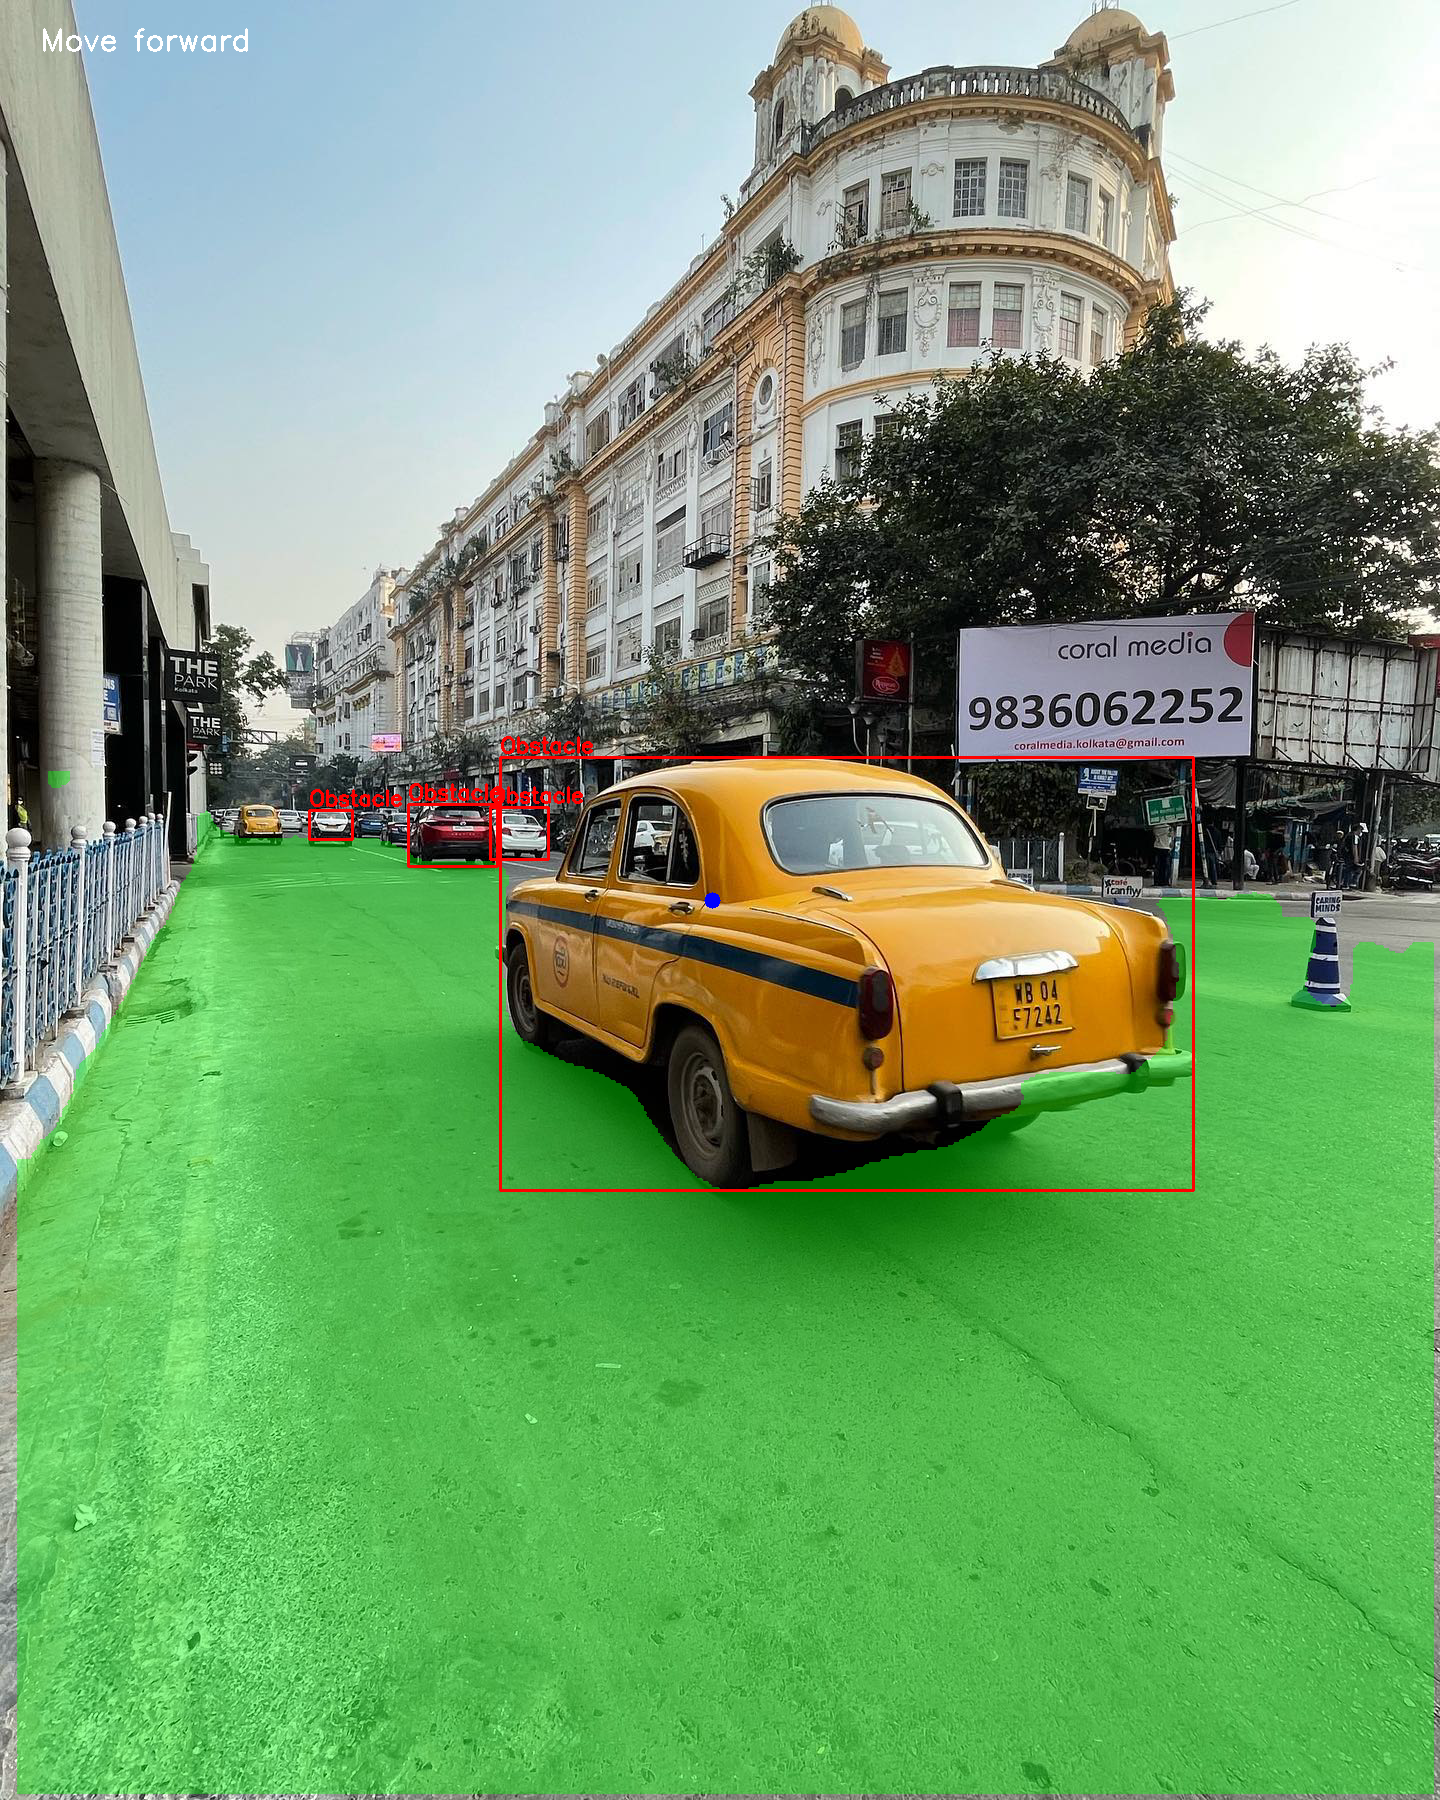

In [17]:
from google.colab import files
import cv2
import numpy as np
from ultralytics import YOLO
from gtts import gTTS
from IPython.display import Audio, display
from google.colab.patches import cv2_imshow
import time

# ---------------------------
# TEXT TO SPEECH
# ---------------------------
def speak(text, filename="voice.mp3"):
    print("[AUDIO]:", text)
    tts = gTTS(text=text, lang='en')
    tts.save(filename)
    display(Audio(filename, autoplay=True))


# ---------------------------
# LOAD MODELS
# ---------------------------
# FOOTPATH SEGMENTATION MODEL
footpath_model = YOLO("/content/best.pt")  # <<< YOUR MODEL

# OBSTACLE DETECTION MODEL
obstacle_model = YOLO("yolov8n.pt")


# ---------------------------
# UPLOAD VIDEO
# ---------------------------
uploaded = files.upload()
video_path = list(uploaded.keys())[0]

cap = cv2.VideoCapture(video_path)


# ---------------------------
# DIRECTION HELPER
# ---------------------------
def get_direction(center_x, width):
    left = width // 3
    right = 2 * width // 3

    if center_x < left:
        return "Move left"
    elif center_x > right:
        return "Move right"
    else:
        return "Move forward"


last_direction = ""
last_obstacle_time = 0
last_speak_time = 0


# ---------------------------
# MAIN LOOP
# ---------------------------
while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_h, frame_w = frame.shape[:2]

    # ---------------------------
    # FOOTPATH SEGMENTATION
    # ---------------------------
    seg = footpath_model(frame, verbose=False)[0]

    walk_center_x = None

    if seg.masks is not None:
        masks = seg.masks.data.cpu().numpy()

        # Largest mask = footpath
        areas = [np.sum(m) for m in masks]
        idx = int(np.argmax(areas))

        mask = masks[idx]
        mask = cv2.resize(mask, (frame_w, frame_h))

        ys, xs = np.where(mask > 0.5)

        if len(xs) > 0:
            walk_center_x = int(np.mean(xs))

        # Green transparent mask overlay
        overlay = frame.copy()
        overlay[mask > 0.5] = (0, 255, 0)
        frame = cv2.addWeighted(frame, 0.6, overlay, 0.4, 0)

    # ---------------------------
    # OBSTACLE DETECTION
    # ---------------------------
    obs_results = obstacle_model(frame, verbose=False)[0]

    OBSTACLE_CLASSES = [0, 1, 2, 3, 5, 7]  # person, bike, car, bus, truck

    obstacle_detected = False

    for box in obs_results.boxes:
        cls = int(box.cls[0])
        conf = float(box.conf[0])

        if cls in OBSTACLE_CLASSES and conf > 0.5:
            obstacle_detected = True

            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
            cv2.putText(frame, "Obstacle", (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    if obstacle_detected and time.time() - last_obstacle_time > 2:
        speak("Obstacle ahead!")
        last_obstacle_time = time.time()

    # ---------------------------
    # DIRECTION GUIDANCE
    # ---------------------------
    if walk_center_x is not None:
        direction = get_direction(walk_center_x, frame_w)

        cv2.circle(frame, (walk_center_x, frame_h//2), 8, (255, 0, 0), -1)
        cv2.putText(frame, direction, (40, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        if direction != last_direction and time.time() - last_speak_time > 1.5:
            speak(direction)
            last_direction = direction
            last_speak_time = time.time()
    else:
        cv2.putText(frame, "No PATH detected", (40, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # ---------------------------
    # DISPLAY
    # ---------------------------
    cv2_imshow(frame)

cap.release()


**REAL TIME** **CAMERAAA**

In [ ]:
# ===============================
# REAL-TIME FOOTPATH + OBSTACLE DETECTION (Google Colab)
# ===============================

from google.colab import files
import cv2
import numpy as np
from ultralytics import YOLO
from gtts import gTTS
from IPython.display import Audio, display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import time

# --------------------------
# 1. Inject JavaScript webcam code
# --------------------------
js = Javascript('''
async function captureFrame() {
    const video = document.createElement('video');
    video.style.display = 'none';
    document.body.appendChild(video);

    const stream = await navigator.mediaDevices.getUserMedia({video: true});
    video.srcObject = stream;

    await new Promise(resolve => video.onloadedmetadata = resolve);
    await video.play();

    // Capture frame
    const canvas = document.createElement('canvas');
    canvas.width = video.videoWidth;
    canvas.height = video.videoHeight;
    const ctx = canvas.getContext('2d');
    ctx.drawImage(video, 0, 0);

    // Stop stream
    stream.getTracks().forEach(t => t.stop());
    video.remove();

    return canvas.toDataURL('image/jpeg', 0.8);
}
''')
display(js)

# --------------------------
# TEXT TO SPEECH
# --------------------------
def speak(text, filename="voice.mp3"):
    print("[AUDIO]:", text)
    tts = gTTS(text=text, lang='en')
    tts.save(filename)
    display(Audio(filename, autoplay=True))

# --------------------------
# LOAD MODELS
# --------------------------
footpath_model = YOLO("/content/best.pt")  # Your custom segmentation model
obstacle_model = YOLO("yolov8n.pt")

# --------------------------
# DIRECTION LOGIC
# --------------------------
def get_direction(center_x, width):
    left = width // 3
    right = 2 * width // 3

    if center_x < left:
        return "Move left"
    elif center_x > right:
        return "Move right"
    else:
        return "Move forward"

last_direction = ""
last_obstacle_time = 0
last_speak_time = 0

OBSTACLE_CLASSES = [0, 1, 2, 3, 5, 7]  # person, bike, car, bus, truck

# --------------------------
# REAL-TIME LOOP
# --------------------------
print("Starting webcam...")

while True:
    try:
        js_frame = eval_js('captureFrame()')
    except:
        print("⚠ Webcam permission blocked or JS not running.")
        break

    img_bytes = b64decode(js_frame.split(',')[1])

    # Convert to OpenCV image
    nparr = np.frombuffer(img_bytes, np.uint8)
    frame = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

    frame_h, frame_w = frame.shape[:2]

    # --------------------------
    # FOOTPATH SEGMENTATION
    # --------------------------
    seg = footpath_model(frame, verbose=False)[0]
    walk_center_x = None

    if seg.masks is not None:
        masks = seg.masks.data.cpu().numpy()
        areas = [np.sum(m) for m in masks]
        idx = int(np.argmax(areas))

        mask = masks[idx]
        mask = cv2.resize(mask, (frame_w, frame_h))

        ys, xs = np.where(mask > 0.5)

        if len(xs) > 0:
            walk_center_x = int(np.mean(xs))

        overlay = frame.copy()
        overlay[mask > 0.5] = (0, 255, 0)
        frame = cv2.addWeighted(frame, 0.6, overlay, 0.4, 0)

    # --------------------------
    # OBSTACLE DETECTION
    # --------------------------
    obs = obstacle_model(frame, verbose=False)[0]
    obstacle_detected = False

    for box in obs.boxes:
        cls = int(box.cls[0])
        conf = float(box.conf[0])

        if cls in OBSTACLE_CLASSES and conf > 0.5:
            obstacle_detected = True
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0,0,255), 2)
            cv2.putText(frame, "Obstacle", (x1, y1-5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

    if obstacle_detected and time.time() - last_obstacle_time > 2:
        speak("Obstacle ahead!")
        last_obstacle_time = time.time()

    # --------------------------
    # DIRECTION
    # --------------------------
    if walk_center_x is not None:
        direction = get_direction(walk_center_x, frame_w)
        cv2.circle(frame, (walk_center_x, frame_h//2), 8, (255, 0, 0), -1)
        cv2.putText(frame, direction, (40, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

        if direction != last_direction and time.time() - last_speak_time > 1.5:
            speak(direction)
            last_direction = direction
            last_speak_time = time.time()

    else:
        cv2.putText(frame, "No footpath detected", (40, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

    # Show output
    cv2_imshow(frame)

